# Code associated with lecture 6

In [4]:
using Gen
using Plots

In [5]:
# Generative model of an urn with unknown ratio of red and blue marbles
# Using the @trace notation
@gen function unknown_urn()
    # p(θ) ̃Uniform(0,1)  [prior distribution]
    theta = @trace(uniform(0, 1), :theta)
    for i=1:10
        # p(y=1|θ) ~ Bernoulli(θ) [likelihood function]
        y = @trace(bernoulli(theta), :data => i => :y)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn#292", Bool[], false)

In [6]:
# same as above, but using the ~ notation
@gen function unknown_urn()
    # p(θ) ̃Uniform(0,1)  [prior distribution]
    theta ~ uniform(0, 1)
    for i=1:10
        # p(y=1|θ) ~ Bernoulli(θ) [likelihood function]
        {:data => i => :y} ~ bernoulli(theta)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn#293", Bool[], false)

In [7]:
# simulate the generative function to draw a sample
trace = simulate(unknown_urn, ())
# look into the random choices (i.e., a sample from the generative model)
Gen.get_choices(trace)

│
├── :theta : 0.004190826955312921
│
└── :data
    │
    ├── 5
    │   │
    │   └── :y : false
    │
    ├── 4
    │   │
    │   └── :y : false
    │
    ├── 6
    │   │
    │   └── :y : false
    │
    ├── 7
    │   │
    │   └── :y : false
    │
    ├── 2
    │   │
    │   └── :y : false
    │
    ├── 10
    │   │
    │   └── :y : false
    │
    ├── 9
    │   │
    │   └── :y : false
    │
    ├── 8
    │   │
    │   └── :y : true
    │
    ├── 3
    │   │
    │   └── :y : false
    │
    └── 1
        │
        └── :y : false


In [120]:
@gen function two_urns()
    theta = @trace(bernoulli(0.5), :urn) ? (0.5) : (0.9)
    for i=1:10
        y = @trace(bernoulli(theta), :data => i => :y)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##two_urns#737", Bool[], false)

In [121]:
@gen function foo()
    if @trace(bernoulli(0.5), :branch)
        @trace(bernoulli(0.5), :x)
    else
        @trace(normal(0, 1), :x)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##foo#738", Bool[], false)

In [8]:
# helper function to create a choicemap with the observed data xs
function make_constraints(ys::Vector{Bool})
    # choicemap to encode observations
    constraints = Gen.choicemap()
    # fill in the choicemap with the observed draws
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    # return the observations
    constraints
end

# **** Start reading this codeblock from here: ****
# we will make observations in a Boolean array
draws = Bool[]
# true=red marble; false=blue marble
# typically data is something we read from file, but in this case we will hand-code it
draws = [true, true,true, true, true, true, false, true, false, true]
observations = make_constraints(draws)

│
└── :data
    │
    ├── 5
    │   │
    │   └── :y : true
    │
    ├── 4
    │   │
    │   └── :y : true
    │
    ├── 6
    │   │
    │   └── :y : true
    │
    ├── 7
    │   │
    │   └── :y : false
    │
    ├── 2
    │   │
    │   └── :y : true
    │
    ├── 10
    │   │
    │   └── :y : true
    │
    ├── 9
    │   │
    │   └── :y : false
    │
    ├── 8
    │   │
    │   └── :y : true
    │
    ├── 3
    │   │
    │   └── :y : true
    │
    └── 1
        │
        └── :y : true


make_constraints (generic function with 1 method)

│
└── :data
    │
    ├── 5
    │   │
    │   └── :y : true
    │
    ├── 4
    │   │
    │   └── :y : true
    │
    ├── 6
    │   │
    │   └── :y : true
    │
    ├── 7
    │   │
    │   └── :y : false
    │
    ├── 2
    │   │
    │   └── :y : true
    │
    ├── 10
    │   │
    │   └── :y : true
    │
    ├── 9
    │   │
    │   └── :y : false
    │
    ├── 8
    │   │
    │   └── :y : true
    │
    ├── 3
    │   │
    │   └── :y : true
    │
    └── 1
        │
        └── :y : true


In [128]:
traces = [first(Gen.importance_resampling(two_urns, (), observations, 1000)) for i in 1:9]

9-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##two_urns#737", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:urn => Gen.ChoiceOrCallRecord{Bool}(true, -0.6931471805599453, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(:data => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(5 => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y => Gen.ChoiceOrCallRecord{Bool}(true, -0.6931471805599453, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), 4 => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y => Gen.ChoiceOrCallRecord{Bool}(true, -0.6931471805599453, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), 6 => Trie{Any, Gen.ChoiceOrCallRec

In [129]:
log_probs = [get_score(t) for t in traces]

9-element Vector{Float64}:
 -7.6246189861593985
 -6.141201491810647
 -6.141201491810647
 -6.141201491810647
 -7.6246189861593985
 -6.141201491810647
 -6.141201491810647
 -6.141201491810647
 -6.141201491810647

In [130]:
urns = Bool[]
urns = [t[:urn] for t in traces]

9-element Vector{Bool}:
 1
 0
 0
 0
 1
 0
 0
 0
 0

In [131]:
# p(θ|observations)
# using "importance resampling" from Gen's library of inference methods
# we run this algorithm 100 times and record the output
traces = [first(Gen.importance_resampling(unknown_urn, (), observations, 1000)) for i in 1:100]

100-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn#740", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:theta => Gen.ChoiceOrCallRecord{Float64}(0.7262401897915236, -0.0, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(:data => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(5 => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y => Gen.ChoiceOrCallRecord{Bool}(true, -0.3198744789395759, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), 4 => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y => Gen.ChoiceOrCallRecord{Bool}(true, -0.3198744789395759, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), 6 => Trie{Any, Gen.Choice

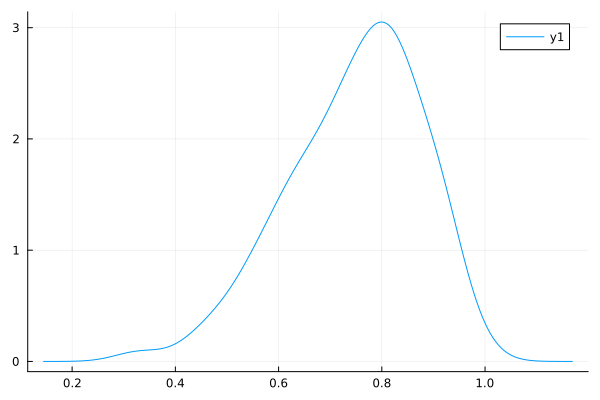

In [133]:
# collect the inferred θs across these 100 chains and plot
thetas = Float64[]
thetas = [t[:theta] for t in traces]
StatsPlots.density(thetas)

In [134]:
@gen function foo(a, b=0)
    z ~ bernoulli(0.5)
    if z
        return a + b + 1
    else
        return a + b
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], true, Union{Nothing, Some{Any}}[nothing, Some(0)], var"##foo#742", Bool[0, 0], false)

In [135]:
# draw a sample from the generative model
trace = Gen.simulate(foo, (3, 5))

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], true, Union{Nothing, Some{Any}}[nothing, Some(0)], var"##foo#742", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:z => Gen.ChoiceOrCallRecord{Bool}(true, -0.6931471805599453, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -0.6931471805599453, 0.0, (3, 5), 9)

In [136]:
# get the random choice made
choices = Gen.get_choices(trace)

│
└── :z : true


In [137]:
# get the return value of the function foo
return_value = Gen.get_retval(trace)

9

In [138]:
@gen function unknown_urn_single()
    # p(θ) ̃Uniform(0,1)  [prior distribution]
    theta ~ uniform(0, 1)
    # p(y=1|θ) ~ Bernoulli(θ) 
    y ~ bernoulli(theta)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn_single#743", Bool[], false)

In [139]:
# draw a sample from the generative model
# notice the args x=() because our generative model
# unknown_urn_single() has no arguments
trace = Gen.simulate(unknown_urn_single, ())

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn_single#743", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y => Gen.ChoiceOrCallRecord{Bool}(true, -0.14314073209582243, NaN, true), :theta => Gen.ChoiceOrCallRecord{Float64}(0.8666320973616668, -0.0, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -0.14314073209582243, 0.0, (), true)

In [140]:
# peek inside the trace
Gen.get_choices(trace)

│
├── :y : true
│
└── :theta : 0.8666320973616668


In [141]:
# draw a trace and return its log score where y=true
(trace, weight) = Gen.generate(unknown_urn_single, (), choicemap((:y, true)))

(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn_single#743", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y => Gen.ChoiceOrCallRecord{Bool}(true, -0.140177428140283, NaN, true), :theta => Gen.ChoiceOrCallRecord{Float64}(0.8692040004670725, -0.0, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -0.140177428140283, 0.0, (), true), -0.140177428140283)

In [142]:
get_choices(trace)

│
├── :y : true
│
└── :theta : 0.8692040004670725


In [143]:
weight

-0.140177428140283

In [144]:
(trace, weight) = Gen.generate(unknown_urn_single, (), choicemap((:theta, 0.9), (:y, true)))

(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn_single#743", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y => Gen.ChoiceOrCallRecord{Bool}(true, -0.10536051565782628, NaN, true), :theta => Gen.ChoiceOrCallRecord{Float64}(0.9, -0.0, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -0.10536051565782628, 0.0, (), true), -0.10536051565782628)

In [145]:
get_choices(trace)

│
├── :y : true
│
└── :theta : 0.9


In [146]:
weight

-0.10536051565782628

In [147]:
@gen function unknown_urn_fancy()
    # p(θ) ̃Uniform(0,1)  [prior distribution]
    theta ~ uniform(0, 1)
    # p(y=1|θ) ~ Bernoulli(θ) 
    y ~ bernoulli(theta)
    # branching logic for p(z|y)
    if y
        z ~ uniform(0, 1)
    else
        z ~ uniform(1, 10)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn_fancy#744", Bool[], false)

In [148]:
# compute the trace and the log probability log p(u;) where t = {theta=0.2, y=true}
(trace, weight) = Gen.generate(unknown_urn_fancy, (), choicemap((:theta, 0.2), (:y, true)))

(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn_fancy#744", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y => Gen.ChoiceOrCallRecord{Bool}(true, -1.6094379124341003, NaN, true), :theta => Gen.ChoiceOrCallRecord{Float64}(0.2, -0.0, NaN, true), :z => Gen.ChoiceOrCallRecord{Float64}(0.5984898244460761, -0.0, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -1.6094379124341003, 0.0, (), 0.5984898244460761), -1.6094379124341003)

In [149]:
# notice that choices include more than u
get_choices(trace)

│
├── :y : true
│
├── :theta : 0.2
│
└── :z : 0.5984898244460761


In [150]:
# log score
weight

-1.6094379124341003

In [151]:
# compute the trace and the log probability log p(t) where t = {theta=0.2, y=true}
(trace, weight) = Gen.generate(unknown_urn_single, (), choicemap((:theta, 0.2), (:y, true)))

(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn_single#743", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y => Gen.ChoiceOrCallRecord{Bool}(true, -1.6094379124341003, NaN, true), :theta => Gen.ChoiceOrCallRecord{Float64}(0.2, -0.0, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -1.6094379124341003, 0.0, (), true), -1.6094379124341003)

## Illustrating Gen.update

In [152]:
@gen function bar()
    a ~ bernoulli(0.3)
    b ~ bernoulli(0.4)
    if b
        c ~ bernoulli(0.6)
        val = c && a
    else
        d ~ bernoulli(0.1)
        val = d && a
    end
    e ~ bernoulli(0.7)
    val = e && val
    return val
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##bar#745", Bool[], false)

In [153]:
trace = Gen.simulate(bar, ())
Gen.get_choices(trace)

│
├── :a : false
│
├── :b : false
│
├── :d : true
│
└── :e : true


In [154]:
# encode the update trace u as a choicemap
constraints = choicemap((:b, false), (:d, true))
# make the update
(new_trace, w, _, discard) = update(trace, (), (), constraints)

(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##bar#745", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:a => Gen.ChoiceOrCallRecord{Bool}(false, -0.35667494393873245, NaN, true), :b => Gen.ChoiceOrCallRecord{Bool}(false, -0.5108256237659907, NaN, true), :d => Gen.ChoiceOrCallRecord{Bool}(true, -2.3025850929940455, NaN, true), :e => Gen.ChoiceOrCallRecord{Bool}(true, -0.35667494393873245, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -3.5267606046375013, 0.0, (), false), 0.0, UnknownChange(), DynamicChoiceMap(Dict{Any, Any}(:b => false, :d => true), Dict{Any, Any}()))

In [155]:
# peek inside the new trace
Gen.get_choices(new_trace)

│
├── :a : false
│
├── :b : false
│
├── :d : true
│
└── :e : true


In [156]:
# choices not used from the original trace t
discard

│
├── :b : false
│
└── :d : true


In [157]:
# log score of the new trace
w

0.0

In [158]:
# encode the update trace u as a choicemap
constraints = choicemap((:b, false))
# make the update
(new_trace, w, _, discard) = update(trace, (), (), constraints)

(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##bar#745", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:a => Gen.ChoiceOrCallRecord{Bool}(false, -0.35667494393873245, NaN, true), :b => Gen.ChoiceOrCallRecord{Bool}(false, -0.5108256237659907, NaN, true), :d => Gen.ChoiceOrCallRecord{Bool}(true, -2.3025850929940455, NaN, true), :e => Gen.ChoiceOrCallRecord{Bool}(true, -0.35667494393873245, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -3.5267606046375013, 0.0, (), false), 0.0, UnknownChange(), DynamicChoiceMap(Dict{Any, Any}(:b => false), Dict{Any, Any}()))

In [159]:
# peek inside the new trace
Gen.get_choices(new_trace)

│
├── :a : false
│
├── :b : false
│
├── :d : true
│
└── :e : true


In [160]:
# log score of the new trace
w

0.0

In [161]:
get_choices(trace)

│
├── :a : false
│
├── :b : false
│
├── :d : true
│
└── :e : true


In [162]:
# regenarate the random choices associated with the addresses a and b
(new_trace, w, _) = Gen.regenerate(trace, (), (), select(:a, :b))

(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##bar#745", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:a => Gen.ChoiceOrCallRecord{Bool}(false, -0.35667494393873245, NaN, true), :b => Gen.ChoiceOrCallRecord{Bool}(false, -0.5108256237659907, NaN, true), :d => Gen.ChoiceOrCallRecord{Bool}(true, -2.3025850929940455, NaN, true), :e => Gen.ChoiceOrCallRecord{Bool}(true, -0.35667494393873245, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -3.5267606046375013, 0.0, (), false), 0.0, UnknownChange())

In [163]:
get_choices(new_trace)

│
├── :a : false
│
├── :b : false
│
├── :d : true
│
└── :e : true


In [164]:
# weight
w

0.0

## More complex generative model with 3 urns/coins

In [165]:
@gen function three_coins()
    # uniform prior over α and β -- using a and b instead
    a ~ uniform(1, 15)
    b ~ uniform(1, 15)
    # draw 3 weighted coins from beta(a,b)
    val = Array{Float64}(undef, 3)
    val[1] = {:coin=>1=>:theta} ~ beta(a, b)
    val[2] = {:coin=>2=>:theta} ~ beta(a, b)
    val[3] = {:coin=>3=>:theta} ~ beta(a, b)
    # flip each coin 40 times
    for i in 1:3
        for j in 1:40
            {:data=>i=>j=>:y} ~ bernoulli(val[i])
        end
    end
end 

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##three_coins#746", Bool[], false)

In [166]:
# helper function to create data where a=14, b=2
# observations are stored in a choicemap that shares
# the same address structure as the generative model
function make_observations_three_coins()
    constraints = Gen.choicemap()
    a = 14
    b = 2
    val = Array{Float64}(undef, 3)
    val[1] = Gen.beta(a, b)
    val[2] = Gen.beta(a, b)
    val[3] = Gen.beta(a, b)
    for i in 1:3
        for j in 1:40
            index = (i-1)*20+j
            constraints[:data=>i=>j=>:y] = Gen.bernoulli(val[i])
        end
    end
    constraints
end 
# call the funciton to get the observations
observations = make_observations_three_coins()

│
└── :data
    │
    ├── 2
    │   │
    │   ├── 5
    │   │   │
    │   │   └── :y : true
    │   │
    │   ├── 16
    │   │   │
    │   │   └── :y : false
    │   │
    │   ├── 20
    │   │   │
    │   │   └── :y : false
    │   │
    │   ├── 35
    │   │   │
    │   │   └── :y : true
    │   │
    │   ├── 12
    │   │   │
    │   │   └── :y : true
    │   │
    │   ├── 24
    │   │   │
    │   │   └── :y : true
    │   │
    │   ├── 28
    │   │   │
    │   │   └── :y : true
    │   │
    │   ├── 8
    │   │   │
    │   │   └── :y : false
    │   │
    │   ├── 17
    │   │   │
    │   │   └── :y : false
    │   │
    │   ├── 30
    │   │   │
    │   │   └── :y : true
    │   │
    │   ├── 1
    │   │   │
    │   │   └── :y : true
    │   │
    │   ├── 19
    │   │   │
    │   │   └── :y : false
    │   │
    │   ├── 22
    │   │   │
    │   │   └── :y : false
    │   │
    │   ├── 23
    │   │   │
    │   │   └── :y : false
    │   │
    │   ├── 6
    │   │   │
    │   │   └── :y :

In [167]:
# perform posterior inference p(a, b|data) using importance resampling
traces = [first(Gen.importance_resampling(three_coins, (), observations, 1000)) for i in 1:50]

50-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##three_coins#746", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:a => Gen.ChoiceOrCallRecord{Float64}(10.800577473477903, -2.6390573296152584, NaN, true), :b => Gen.ChoiceOrCallRecord{Float64}(1.5947835779615112, -2.6390573296152584, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(:data => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(2 => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(5 => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y => Gen.ChoiceOrCallRecord{Bool}(true, -0.34641089480511916, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()),

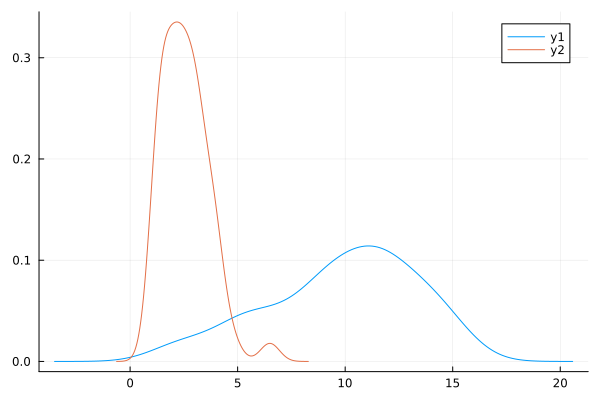

In [168]:
# collect the inferred as and bs across the chains and plot
as = Float64[]
bs = Float64[]
as = [t[:a] for t in traces]
bs = [t[:b] for t in traces]
StatsPlots.density([as, bs])

## Static annotation

In [169]:
@gen function foo_dynamic(x::Float64)
    # draw the mean of a normal dist. w/ a coin flip
    if @trace(bernoulli(0.5), :branch)
        mu = x
    else
        mu = 1/x
    end
    # draw the normal distribution
    z = @trace(normal(mu, 1), :z)
end
trace = Gen.simulate(foo_dynamic, (3.0,))
get_choices(trace)

│
├── :branch : true
│
└── :z : 2.6382706573019994


In [170]:
@gen (static) function foo_static(x::Float64)
    # in static annotation, you can use the "? :" branching
    # but it can't be a top-level expression 
    # e.g., it can be on the right-hand side
    mu = @trace(bernoulli(0.5), :branch) ? (x) : (1/x)
    # draw the normal distribution
    @trace(normal(x, 1), :z)
end
@load_generated_functions
trace = Gen.simulate(foo_static, (3.0,))
get_choices(trace)

│
├── :branch : false
│
└── :z : 2.4113882683895906


In [171]:
mu, sigma = @trace(bernoulli(p), :x) ? (mu1, sigma1) : (mu2, sigma2)

LoadError: syntax: invalid syntax (gentrace (call (outerref bernoulli) (outerref p)) #<julia: Base.Some{QuoteNode}(value=:(:x))>)

In [172]:
@trace(bernoulli(1-prob_tails), :flip)

LoadError: syntax: invalid syntax (gentrace (call (outerref bernoulli) (call (outerref -) 1 (outerref prob_tails))) #<julia: Base.Some{QuoteNode}(value=:(:flip))>)

In [173]:
return @trace(geometric(prob), :n_flips) + 1

LoadError: syntax: invalid syntax (gentrace (call (outerref geometric) (outerref prob)) #<julia: Base.Some{QuoteNode}(value=:(:n_flips))>)

## Combinator example using Map

In [222]:
@gen function unknown_urn()
    # p(θ) ̃Uniform(0,1)  [prior distribution]
    theta ~ uniform(0, 1)
    for i=1:100
        # p(y=1|θ) ~ Bernoulli(θ) [likelihood function]
        {:data => i => :y} ~ bernoulli(theta)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn#1269", Bool[], false)

In [204]:
# kernel generative function G_k
@gen (static) function observe_flip(theta::Float64)
    # p(y|θ) ~ Bernoulli(θ) [likelihood function]
    y ~ bernoulli(theta)
    return y
end

@gen (static) function unknown_urn_static(k::Int64)
    # prior over coin weight p(θ)
    theta ~ uniform(0,1)
    # called k times
    data ~ Gen.Map(observe_flip)(fill(theta, k))
end

var"##StaticGenFunction_unknown_urn_static#1221"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [207]:
# need this to load the static functions
@load_generated_functions

# get a draw and peek inside
(trace, _) = generate(unknown_urn_static, (3,))
get_choices(trace)

│
├── :theta : 0.7826638301422892
│
└── :data
    │
    ├── 1
    │   │
    │   └── :y : true
    │
    ├── 2
    │   │
    │   └── :y : true
    │
    └── 3
        │
        └── :y : true


In [175]:
# this is our kernel G_k
@gen function foo(x1::Float64, x2::Float64)
    # draw a normal based on the arguments 
    y = @trace(normal(x1 + x2, 1.0), :z)
    # and return it
    return y
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##foo#776", Bool[0, 0], false)

In [176]:
bar = Map(foo)

Map{Any, Gen.DynamicDSLTrace}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##foo#776", Bool[0, 0], false))

In [177]:
(trace, _) = generate(bar, ([0.0, 0.5], [0.5, 1.0]))
get_choices(trace)

│
├── 1
│   │
│   └── :z : 2.3974942945865094
│
└── 2
    │
    └── :z : 1.7573092528497942


[ Info:  started timer at: 2023-08-18T08:56:34.888
[ Info:          3.804121279s: 3 seconds, 804 milliseconds


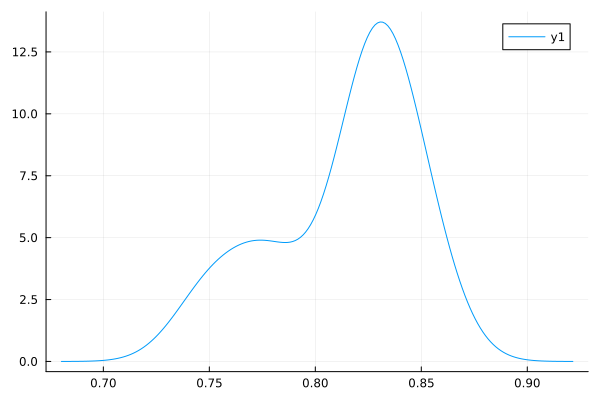

In [227]:
tick()
# using "importance resampling" from Gen's library of inference methods
traces = [first(Gen.importance_resampling(unknown_urn, (), observations, 1000)) for i in 1:10]
tock()
# collect the inferred θs across these 100 chains and plot
thetas = Float64[]
thetas = [t[:theta] for t in traces]
StatsPlots.density(thetas)

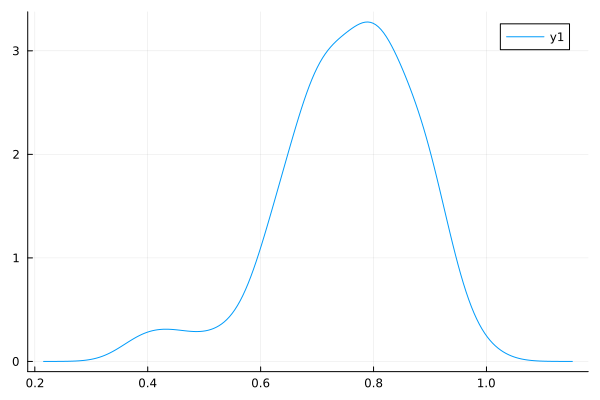

In [236]:
# using "importance resampling" from Gen's library of inference methods
traces = [first(Gen.importance_resampling(unknown_urn_static, (10,), observations, 1000)) for i in 1:100]
# collect the inferred θs across these 100 chains and plot
thetas = Float64[]
thetas = [t[:theta] for t in traces]
StatsPlots.density(thetas)